###### Introduction

This document introduces the use of XeThru Development Platform from a host computer and introduces use of the X4 chip. This guide use the following hardware and software components:

* [XeTru Embedded Platform (XEP)](https://www.xethru.com/community/resources/categories/xethru-embedded-platform.35/) compatible hardware.
* Host library [Module Connector](https://www.xethru.com/community/resources/categories/module-connector.32/).

Module Connector is a C++ library with wrappers for Matlab and Python. The wrappers supports the same functionality, but differs at some points. Python is used in this guide.

<!---
This Jupyter Notebook is available in TODO.
-->

# Installation

## Prerequisites


**Python**

* Python 2.7
* numpy
* matplotlib

It is recommended to install the python distribution package anaconda from continuum: https://www.continuum.io/downloads which contains most packages needed.

## Module Connector 

Download the latest version for your platform here: https://www.xethru.com/community/resources/categories/module-connector.32/. Unzip the folder and see the various README.txt files in the root folder, python/ folder or matlab/ folder for documentation and installation.

## Test python installation

Connect a X4M03 module to the computer and start an ipython session with interactive matplotlib and pylab enabled:

> ipython --pylab

The following commands imports the python version of Module Connector and prints the version:

```python
import pymoduleconnector
print pymoduleconnector.__version__
1.1.5
```

Find the device name of your device and the following code will connect to a module, get the XEP interface and plot one frame:


```python
from pymoduleconnector import ModuleConnector

device_name = 'COM4'
mc = ModuleConnector(device_name)
r = mc.get_xep()
# Start sampling and streaming of radar data
r.x4driver_set_fps(10)
frame = np.array(r.read_message_data_float().data)
# Stop streaming
r.x4driver_set_fps(0)
plot(frame)
```


# XEP Interface Example Usage

This section demonstrates the X4Driver interface. Code blocks starts with "In [n]" and can be run in an ipython session. An X4M03 module with XEP is connected to the computer with an USB cable.



In [2]:
import pymoduleconnector
from pylab import *
%matplotlib inline
rcParams['figure.figsize'] = [20, 10]

ImportError: No module named pymoduleconnector

First define some helper functions that we will use later on:


In [ ]:
def reset(device_name):
    """Reset module and wait until the device is enumarated again.
    
    Note that the connection to the module must be closed before using this function.
    """
    from time import sleep
    mc = pymoduleconnector.ModuleConnector(device_name)
    r = mc.get_xep()
    r.module_reset()
    mc.close()
    sleep(3)

def clear_buffer(radar):
    """Clears the frame buffer.
    x4driver_set_fps starts streaming data and fills the host frame buffer with data.
    This functions reads data until the buffer is empty.
    
    Frame data streaming is temporarily stopped while emptying the buffer.
    """
    fps = radar.x4driver_get_fps()
    while radar.peek_message_data_float():
        _=radar.read_message_data_float()
    radar.x4driver_set_fps(fps)
    
def read_frame_normalized(radar):
    """Reads a frame from the frame buffer.

    The frame buffer is filled by enabling streaming with x4driver_set_fps
    
    Returns:
        The frame array as read from the frame buffer.
    """
    d = radar.read_message_data_float()
    frame = np.array(d.data)
    return frame

def get_frame_normalized(radar):
    """Convinience function to sample 1 frame, reads and returns the result.
    
    This function will stop streaming if the radar is already streaming.
    Use streaming mode to sample several frames.
    
    Returns:
        The frame array as read from the frame buffer.
    """
    clear_buffer(radar)
    radar.x4driver_set_fps(10)
    d = radar.read_message_data_float()
    radar.x4driver_set_fps(0)
    clear_buffer(radar)
    frame = np.array(d.data)
    # Convert the resulting frame to a complex array if downconversion is enabled
    # Should probably be implemented without reading chip registers in the future.
    if bitwise_and(radar.x4driver_get_pif_register(0x0f),1):
        n=len(frame)
        frame = frame[:n/2] + 1j*frame[n/2:]
    return frame

def get_frame_normalized(radar):
    """Convinience function to sample 1 frame, reads and returns the result.
    
    This function will stop streaming if the radar is already streaming.
    Use streaming mode to sample several frames.
    
    Returns:
        The frame array as read from the frame buffer.
    """
    clear_buffer(radar)
    radar.x4driver_set_fps(10)
    d = radar.read_message_data_float()
    radar.x4driver_set_fps(0)
    clear_buffer(radar)
    frame = np.array(d.data)
    # Convert the resulting frame to a complex array if downconversion is enabled
    # Should probably be implemented without reading chip registers in the future.
    if bitwise_and(radar.x4driver_get_pif_register(0x0f),1):
        n=len(frame)
        frame = frame[:n/2] + 1j*frame[n/2:]
    return frame

def get_frames_normalized(radar, n, fps = 40):
    """!Streams frames for approximately n/fps seconds.

    The chip is set up to stream fps frames per second, streaming is started
    and sampled for n/fps seconds. Chips settings are not checked, so make
    sure that the given fps is possible.

    Returns:
        Array of normalized frames
    """
    from time import sleep
    clear_buffer(radar)
    radar.x4driver_set_fps(fps)
    sleep(1.0*n/fps)
    radar.x4driver_set_fps(fps)
    frames = array(q.queue)/self._nfactor+self._noffset

    self.log.info("Sampled %d frames, goal was %d"%(len(frames), n))

    return frames

    

def get_fs(radar):
    """Get the radar system sampling rate.

    Returns:
        Sampling rate in Hz
    """
    # Read PIF register and mask out the rx_downconversion_enable bit
    rx_downconversion_enable = bitwise_and(radar.x4driver_get_pif_register(0x0F),1)
    if rx_downconversion_enable:
        f=8.0
    else:
        f=1.0
    return  243*8*12/1e3*1e9/f

In [ ]:
DEVICE_NAME = 'com4'
reset(DEVICE_NAME)

In [ ]:
mc = pymoduleconnector.ModuleConnector(DEVICE_NAME)
r = mc.get_xep()

## Sampling frames

The radar is setup and ready to sample frames. A single normilzed frame is sampled with:

In [ ]:
print get_frame_normalized.__doc__

In [ ]:
# Set start and stop of the frame in meters
r.x4driver_set_frame_area(0,10)
farea = r.x4driver_get_frame_area()
farea_offset = r.x4driver_get_frame_area_offset()
print "Actual frames starts at %g meters and ends at %g meters"%(farea.start, farea.end)
print "given a frame area offset of %g meters"%(farea_offset)

In [ ]:
# Set the start of the frame to include the direct coupling from TX to RX
RX_WAIT_ADDRESS = 0x42
#TX_WAIT_ADDRESS = 0x43
r.x4driver_set_pif_register(RX_WAIT_ADDRESS, 0)
#r.x4driver_set_pif_register(TX_WAIT_ADDRESS, 1)

In [ ]:
frame = get_frame_normalized(r)
frame
#plot(data)

Streaming data at a given frame rate is important in many applications, streaming if data should then be started and read from the frame buffer, here's a pseudocode example:

```
FPS=20
x4driver_set_fps(FPS)

while application_is_running:
    frame = read_frame_normalized()
    process_single_frame(frame)

```

In [ ]:
TX_CENTER_FREQUENCY_EU_7_290GHz  = 3
TX_CENTER_FREQUENCY_KCC_8_748GHz = 4

r.x4driver_set_tx_center_frequency(TX_CENTER_FREQUENCY_EU_7_290GHz)
frame_etsi = get_frame_normalized(r)
# Change transmitter center frequency from the to kcc
r.x4driver_set_tx_center_frequency(TX_CENTER_FREQUENCY_KCC_8_748GHz)
# Increase PG power for KCC transmitter
r.x4driver_set_tx_power(3)
frame_kcc = get_frame_normalized(r)
# we'll use the etsi transmitter for now
r.x4driver_set_tx_center_frequency(TX_CENTER_FREQUENCY_EU_7_290GHz)
r.x4driver_set_tx_power(2)

fs = get_fs(r)
bins = len(data)
distx =  np.arange(bins)/fs*3e8/2
frame_etsi

In [ ]:
figure(figsize = (20,10))
subplot(211)
plot(data, label='etsi')
plot(data, label='kcc')
xlabel('Bin #')
ylabel('DACValue (0 - 2047)')
xlim(0,bins)
legend()
grid()
ax = gca().twiny()
ax.set_xlim(distx[0], distx[-1])
title("Sampled frame")
print "One frame consist of %d bins, sampled at %g GHz, corresponding to %g meters"%(bins, fs/1e9, distx[-1])

subplot(212)
psd(frame_etsi, Fs = fs/1e9, label = 'etsi')
psd(frame_kcc, Fs = fs/1e9, label = 'kcc')
ylabel("Power")
_=title("PSD of the sampled frame. Remember that this does not reflect the actual transmitted power.")

## On-chip Downconversion to Baseband and Decimation

X4 can downconvert the data which greatly reduces the amount of data to be processed. The 1536 bins long frame is downconverted and decimated resulting in 188 complex bins.

In [ ]:
r.x4driver_set_downconversion(1)
# This changes the sample delat, set it back to 0
r.x4driver_set_pif_register(RX_WAIT_ADDRESS,0)

In [ ]:
frame = get_frame_normalized(r)
fs = get_fs(r)
bins = len(frame)
distx =  np.arange(bins)/fs*3e8/2

In [ ]:
figure(figsize = (20,10))
plot(real(frame), label='real')
plot(imag(frame), label='imag')
plot(abs(frame), label='abs')

xlabel('Bin #')
ylabel('DACValue (0 - 2047)')
xlim(0,bins)
grid()
legend()
ax = gca().twiny()
ax.set_xlim(distx[0], distx[-1])
title("Sampled frame")
print "One frame consist of %d bins, sampled at %g GHz, corresponding to %g meters"%(bins, fs/1e9, distx[-1])

## Adjusting Sweep parameters

Some of the default settings are:

In [201]:
mc.close()
reset(DEVICE_NAME)
mc = pymoduleconnector.ModuleConnector(DEVICE_NAME)
r = mc.get_xep()
# Set the start of the frame to include the direct coupling from TX to RX
r.x4driver_set_pif_register(RX_WAIT_ADDRESS, 0)

bins = len(get_frame_normalized(r))

# Note: Read chip parameters directly from chip when not
# (yet) implemented in MC
def get_prf(radar):
    """Get the configured PRF

    Returns:
        Frequency in hz
    """
    trx_clocks_per_pulse = radar.x4driver_get_pif_register(0x2c)
    return 243e6 / trx_clocks_per_pulse

def get_iterations(radar):
    """Read and rteturns the configured iterations from chip."""
    iterations = radar.x4driver_get_pif_register(0x35)
    return iterations

def get_pps(radar):
    """Read and returns the configured pulses_per_step from chip."""
    pps = (radar.x4driver_get_pif_register(0x2e)<<8) + radar.x4driver_get_pif_register(0x2f)
    return pps


print "\nDefault settings"
print "#"*30
print "Iterations:    %d"%(get_iterations(r))
print "PulsesPerStep: %d"%(get_pps(r))
print "PRF:           %g MHz"%(get_prf(r)/1e6)
print "PRI:           %g ns"%(1/get_prf(r)*1e9)
print "Frame length:  %g ns"%((bins-1)/get_fs(r)*1e9)


Default settings
##############################
Iterations:    8
PulsesPerStep: 10
PRF:           15.1875 MHz
PRI:           65.8436 ns
Frame length:  62.8429 ns


Accepting clipping of the direct coupled TX to RX pulse, the DAC range can be narrowed to some range around the frame mean, for example:

In [202]:
dacmin = int(2047/2) - 100
dacmax = int(2047/2) + 100
r.x4driver_set_dac_min(dacmin)
r.x4driver_set_dac_max(dacmax)

In [203]:
frame = get_frame_normalized(r)

Text(0.5,1,'Note that y-scale normalization is wrong')

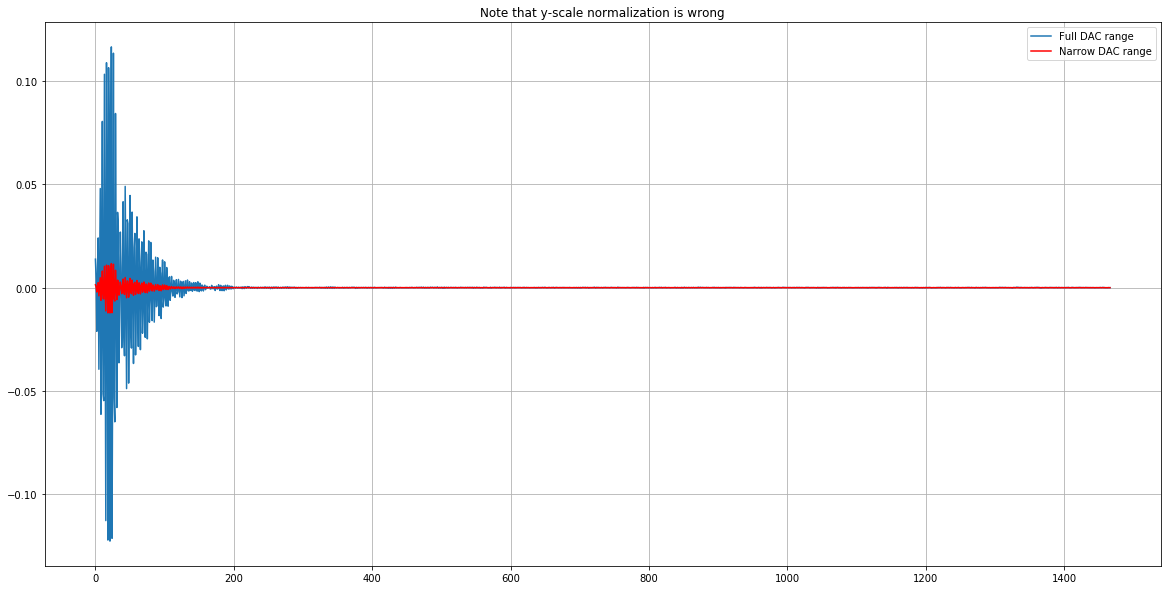

In [204]:
figure(figsize=(20,10))

plot(data, label = 'Full DAC range')

#Note Normalization goes wrong, the following scaling of the frame is just
# to better show the effect of a narrow DAC range and is more similar to reality
plot(data*.1,'r', label = 'Narrow DAC range')
legend()
grid()
title("Note that y-scale normalization is wrong")

Given a desired FPS, PulsesPerSteps can be calculated.

In [205]:
fps = 50
pps = 1/((dacmax-dacmin+1)*r.get_iterations()/r.get_prf()*fps)
# Scale by 0.8
pps = int(pps * 0.8)
r.set_pps(pps)
# Test if the desired fps is possible:
frames = r.get_frames_normalized(200, fps)

AttributeError: type object 'object' has no attribute '__getattr__'

Let's enable downconvertion and sample a data set. A person walks from behind the sensor, through the office door, to the wall and back:

In [ ]:
r.enable_downconversion()

In [229]:
from time import sleep
raw_input("Walk towards the radar and back, will start after 5 seconds [enter]")
sleep(5)
frames = r.get_frames_normalized(700, fps)

Walk towards the radar and back, will start after 5 seconds [enter]


AttributeError: type object 'object' has no attribute '__getattr__'

In [324]:
#fs = get_fs(r)
bins = len(data)
distx =  np.arange(bins)/fs*3e8/2

TypeError: Dimensions of C (1467L, 0L) are incompatible with X (1467) and/or Y (1467); see help(pcolormesh)

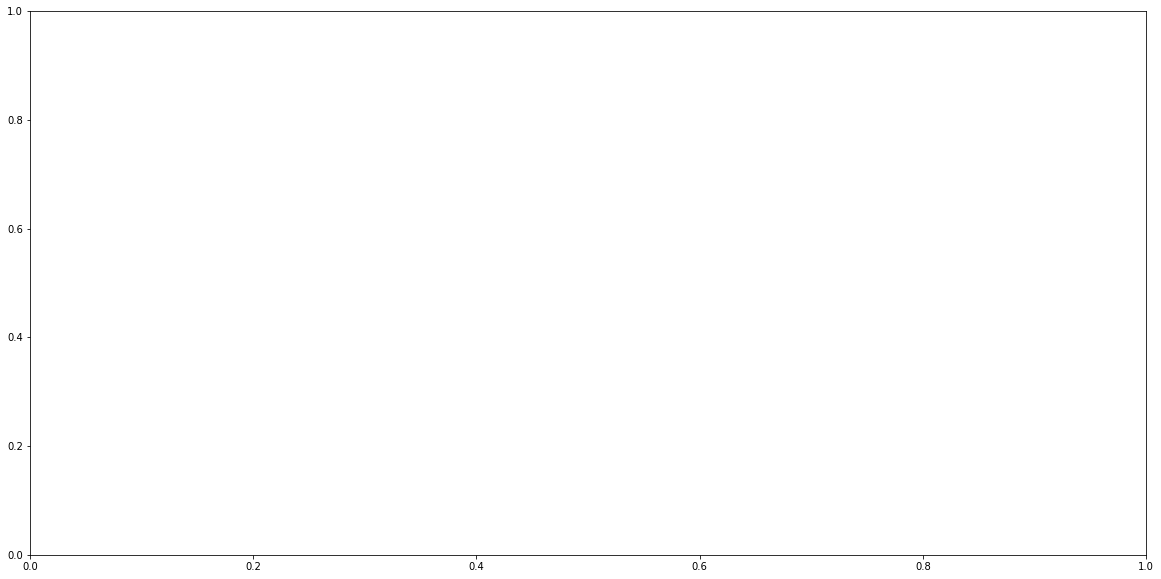

In [331]:
figure(figsize=(20,10))
try:
    X,Y = np.meshgrid(distx, arange(0,len(data)/10,1/10))
except ZeroDivisionError:
    pass
f=np.abs(diff(data))
pcolormesh(X,Y,f, cmap=cm.jet)
xlabel("Distance (m)")
ylabel("Time (s)")
title("")

In [285]:
# Close the connection
mc.close()

In [ ]:
d = r.read_message_data_float()